In [1]:
import numpy as np
import pandas as pd
import datetime  
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(101)

%matplotlib inline

# Set plotting styles
sns.set_style('white')
import warnings 
warnings.simplefilter('ignore')

C:\Users\laptop\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\laptop\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\laptop\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score,f1_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

# USER

In [4]:
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
users.rename(columns={'object_id':'user_id'}, inplace=True)

# ENGAGEMENT

In [8]:
engagements = pd.read_csv('takehome_user_engagement.csv')
engagements.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [9]:
engagements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [11]:
engagements['time_stamp'] = pd.to_datetime(engagements['time_stamp'])

In [12]:
engagements = engagements.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W')])[['visited']].count()
# = user_eng['week/year'] = user_eng['time_stamp'].apply(lambda x: "%d/%d"% (x.week, x.year))
engagements = engagements.reset_index()

# getting weekly count max per user
engagements = engagements.groupby('user_id')['visited'].max()
engagements = engagements.reset_index()

# determining adopted users
engagements['adopted_user'] = np.where(engagements['visited'] >= 3, 1, 0)
engagements.head()

,user_id,visited,adopted_user
0,1,1,0
1,2,3,1
2,3,1,0
3,4,1,0
4,5,1,0


# MERGED DATA

In [14]:
df = engagements.merge(users, how='inner', on='user_id', sort=True)
df.head()

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,1,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,1,0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1,0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [15]:
df.isnull().sum()

user_id                          0
visited                          0
adopted_user                     0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
dtype: int64

In [17]:
df['invited_by_user_id'].fillna(0, inplace=True)
df['invited_by_user_id'] = df['invited_by_user_id'].astype(int)

In [18]:
df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time)
df['active_days'] = df['last_session_creation_time'] - df['creation_time']
df['active_days'] = df['active_days'].dt.days

In [20]:
df.head()

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803,-16183
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316,-16025
2,3,1,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525,-15784
3,4,1,0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151,-15847
4,5,1,0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240,-15723


In [22]:
df_ml = df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
              'org_id', 'invited_by_user_id', 'active_days', 'adopted_user' ]]
df_ml.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,adopted_user
0,GUEST_INVITE,1,0,11,10803,-16183,0
1,ORG_INVITE,0,0,1,316,-16025,1
2,ORG_INVITE,0,0,94,1525,-15784,0
3,GUEST_INVITE,0,0,1,5151,-15847,0
4,GUEST_INVITE,0,0,193,5240,-15723,0


In [23]:
df_ml.adopted_user.value_counts()

0    7378
1    1445
Name: adopted_user, dtype: int64

In [24]:
df_ml_class1 = df_ml[df_ml['adopted_user']==1]
df_ml_class0 = df_ml[df_ml['adopted_user']==0]

In [26]:
df_ml_class0_sampled = df_ml_class0.sample(n=len(df_ml_class1), random_state=101)
df_ml_balanced = df_ml_class0_sampled.append(df_ml_class1)

In [27]:
df_ml_balanced.adopted_user.value_counts()

0    1445
1    1445
Name: adopted_user, dtype: int64

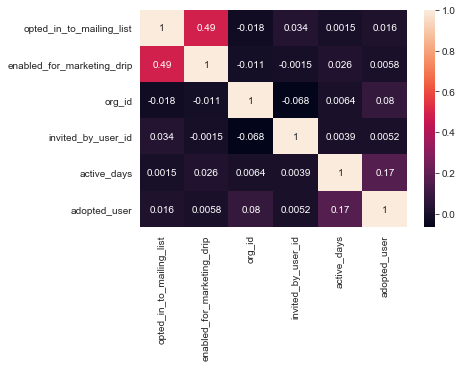

In [28]:
corr = df_ml_balanced.corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns, yticklabels=corr.columns)

In [29]:
creation_source_dum = pd.get_dummies(df_ml_balanced['creation_source'], drop_first=True)

In [30]:
df_ml_balanced.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,adopted_user
7588,ORG_INVITE,0,0,20,7928,-15552,0
1430,ORG_INVITE,0,0,277,2120,-16194,0
3204,PERSONAL_PROJECTS,0,0,315,0,-15923,0
6439,GUEST_INVITE,0,0,6,11999,-15729,0
1385,SIGNUP,0,1,74,0,-15979,0


In [31]:
df_ml_balanced.drop(['creation_source'], axis=1, inplace=True)

In [32]:
X = pd.concat([df_ml_balanced, creation_source_dum], axis=1)
X.drop(['adopted_user'], axis=1, inplace=True)
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
7588,0,0,20,7928,-15552,1,0,0,0
1430,0,0,277,2120,-16194,1,0,0,0
3204,0,0,315,0,-15923,0,1,0,0
6439,0,0,6,11999,-15729,0,0,0,0
1385,0,1,74,0,-15979,0,0,1,0


In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2890 entries, 7588 to 8812
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    2890 non-null   int64
 1   enabled_for_marketing_drip  2890 non-null   int64
 2   org_id                      2890 non-null   int64
 3   invited_by_user_id          2890 non-null   int32
 4   active_days                 2890 non-null   int64
 5   ORG_INVITE                  2890 non-null   uint8
 6   PERSONAL_PROJECTS           2890 non-null   uint8
 7   SIGNUP                      2890 non-null   uint8
 8   SIGNUP_GOOGLE_AUTH          2890 non-null   uint8
dtypes: int32(1), int64(4), uint8(4)
memory usage: 135.5 KB


In [33]:
y = df_ml_balanced['adopted_user']
y.head()

7588    0
1430    0
3204    0
6439    0
1385    0
Name: adopted_user, dtype: int32

# MODELS

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [40]:
def model_evaluation(model,params,avg):
    
    pipe = make_pipeline(StandardScaler(),model)
    model_ran = RandomizedSearchCV(pipe,params,cv=5, n_jobs=-1, scoring = 'roc_auc',random_state = 42)
    model_ran = model_ran.fit(X_train,y_train)
    y_pred = model_ran.predict(X_test)
    y_pred_proba = model_ran.predict_proba(X_test)[:,1]
    f1 = f1_score(y_test, y_pred, average= avg)
    cm = confusion_matrix(y_test, y_pred)
    roc= roc_auc_score(y_test, y_pred_proba)
    print('F1-score: ' , round(f1,4))
    print("Best Score: " , round(model_ran.best_score_,4))
    print("ROC AUC:", round(roc,4), '\n')
    print("Best Parameters: " , model_ran.best_params_)
    print("Confusion Matrix: " ,'\n', cm, '\n')
    print("Classsification Report: ",'\n', classification_report(y_test, y_pred))
    y_pred_proba=model_ran.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr,tpr,label= 'f"{model}" ')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

[23:19:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1-score:  0.5852
Best Score:  0.5688
ROC AUC: 0.6108 

Best Parameters:  {'xgbclassifier__subsample': 0.91, 'xgbclassifier__silent': 1, 'xgbclassifier__seed': 27, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__nthread': 10, 'xgbclassifier__n_estimators': 1000, 'xgbclassifier__min_child_

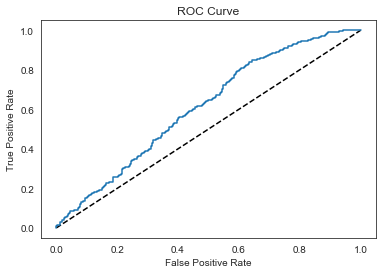

In [43]:
xg_params= {'xgbclassifier__nthread':[10], #when use hyperthread, xgboost may become slower
              'xgbclassifier__objective':['binary:logistic'],
              'xgbclassifier__learning_rate': [0.05], #so called `eta` value
              'xgbclassifier__max_depth': [2],
              'xgbclassifier__min_child_weight': [1],
              'xgbclassifier__silent': [1],
              'xgbclassifier__subsample': [.89,.91,.895],
              'xgbclassifier__colsample_bytree': [.58,.585],
              'xgbclassifier__n_estimators': [1000],
             'xgbclassifier__seed': [27]
            }            #number of trees, change it to 1000 for better results 
avg= 'binary'

xgb=XGBClassifier()

model_evaluation(XGBClassifier(), xg_params, avg)

F1-score:  0.6808
Best Score:  0.6056
ROC AUC: 0.6587 

Best Parameters:  {'randomforestclassifier__n_estimators': 819, 'randomforestclassifier__max_depth': 2}
Confusion Matrix:  
 [[150 308]
 [ 39 370]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.79      0.33      0.46       458
           1       0.55      0.90      0.68       409

    accuracy                           0.60       867
   macro avg       0.67      0.62      0.57       867
weighted avg       0.68      0.60      0.57       867



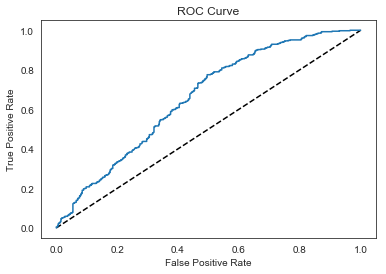

In [44]:
params=  {'randomforestclassifier__n_estimators': np.arange(50,2000),
         'randomforestclassifier__max_depth' :  np.arange(2,20)}
avg= 'binary'

model_evaluation(RandomForestClassifier(), params, avg)

F1-score:  0.6196
Best Score:  0.5792
ROC AUC: 0.6255 

Best Parameters:  {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__p': 1, 'kneighborsclassifier__n_neighbors': 174, 'kneighborsclassifier__leaf_size': 8}
Confusion Matrix:  
 [[212 246]
 [115 294]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.65      0.46      0.54       458
           1       0.54      0.72      0.62       409

    accuracy                           0.58       867
   macro avg       0.60      0.59      0.58       867
weighted avg       0.60      0.58      0.58       867



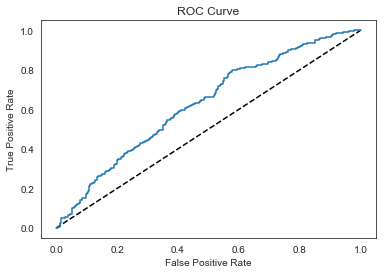

In [45]:
knn_params = {'kneighborsclassifier__leaf_size': np.arange(1,50), 
               'kneighborsclassifier__n_neighbors': np.arange(1,200),'kneighborsclassifier__p':[1,2],
             'kneighborsclassifier__weights': ['uniform', 'distance'] }
avg= 'binary'
knn= KNeighborsClassifier()
model_evaluation(knn,knn_params,avg)

# The Best Model

Accuracy: 0.6070192782995552 

Feature ranking:


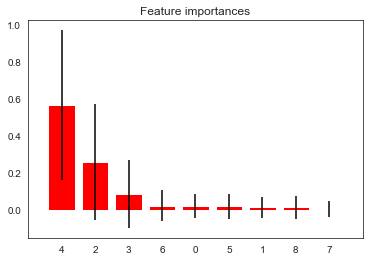

,features,importance
4,active_days,0.564528
2,org_id,0.256252
3,invited_by_user_id,0.085390
6,PERSONAL_PROJECTS,0.022259
0,opted_in_to_mailing_list,0.019907
5,ORG_INVITE,0.019076
1,enabled_for_marketing_drip,0.013501
8,SIGNUP_GOOGLE_AUTH,0.013188
7,SIGNUP,0.005898


In [55]:
import shap
rf= RandomForestClassifier(n_estimators= 819, max_depth= 2)

rf.fit(X_train, y_train.ravel())
Accuracy=rf.score(X_train, y_train.ravel())
print('Accuracy:',Accuracy,'\n')

importFeature = rf.feature_importances_
feature_importances=pd.DataFrame([importFeature])

std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importFeature)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importFeature[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

feature_importances=pd.DataFrame(pd.Series(X.columns)[indices])
feature_importances['importance']=np.sort(importFeature)[::-1]
feature_importances.columns=['features','importance']
feature_importances